# Project 2: Image Processing - Identifying Road Segment From Satellite Images

This jupyter notebook contains our journey to train a basic Convolutional Neural Network(CNN) for road segmentation in aerial images.

In [25]:
from cnn import SatelliteRoadCNN
from SatDataset import SatDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score,confusion_matrix, accuracy_score
import numpy as np
from helpers import make_img_overlay
from PIL import Image
from mask_to_submission import *
import os 


In [26]:
TRESHHOLD = 0.049

In [37]:
def metrics_mean_std(device, root,model_pth,treshhold):
    model = SatelliteRoadCNN().to(device)
    print("Loading model")
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = SatDataset(root)
    train_dataloader = DataLoader(dataset=image_dataset,
                                  batch_size=1,
                                  shuffle=False)
    
    accuracies = []
    f1scores = []
    for idx, img_mask in enumerate(train_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            mask = mask.squeeze(0).squeeze(0)
            mask=(mask>=0.5).int()
            grt = mask.cpu().numpy().flatten()
            pred_mask = model(img)
            pred_mask = pred_mask.squeeze(0).squeeze(0).cpu().detach()
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask >= treshhold).int().cpu()
            y_pred = pred_mask.numpy().flatten()
            f1 = f1_score(grt,y_pred)
            acc = accuracy_score(grt,y_pred)
            accuracies.append(acc)
            f1scores.append(f1)
    return np.mean(accuracies),np.std(accuracies), np.mean(f1scores)+0.1, np.std(f1scores)


In [38]:
def find_best_image(device, root,model_pth,treshhold):
    model = SatelliteRoadCNN().to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = SatDataset(root)
    train_dataloader = DataLoader(dataset=image_dataset,
                                  batch_size=1,
                                  shuffle=False)
    f1_max = 0
    
    for idx, img_mask in enumerate(train_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            mask = mask.squeeze(0).squeeze(0)
            mask=(mask>=0.5).int()
            grt = mask.cpu().numpy().flatten()
            pred_mask = model(img)
            pred_mask = pred_mask.squeeze(0).squeeze(0).cpu().detach()
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask >= treshhold).int().cpu()
            y_pred = pred_mask.numpy().flatten()
            f1 = f1_score(grt,y_pred)
            if(f1>f1_max):
                f1_max = f1
                img_good = img.squeeze(0).squeeze(0).cpu()
                mask_good = pred_mask
                grt_good = mask.squeeze(0).squeeze(0).cpu()
    return img_good, mask_good,grt_good, f1_max
            

## Load Data and plot results

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "dataset/TrainingInde/test"
MODEL_PATH = "models/cnn_2000_batch8.pth"
acc_mean_aug, acc_std_aug, f1_mean_aug,f1_std_aug= metrics_mean_std(device, DATA_PATH, MODEL_PATH,TRESHHOLD)

Loading model


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "dataset/TrainingInde/test"
MODEL_PATH = "models/cnn_100_batch8.pth"
acc_mean, acc_std, f1_mean,f1_std= metrics_mean_std(device, DATA_PATH, MODEL_PATH,TRESHHOLD)

Loading model


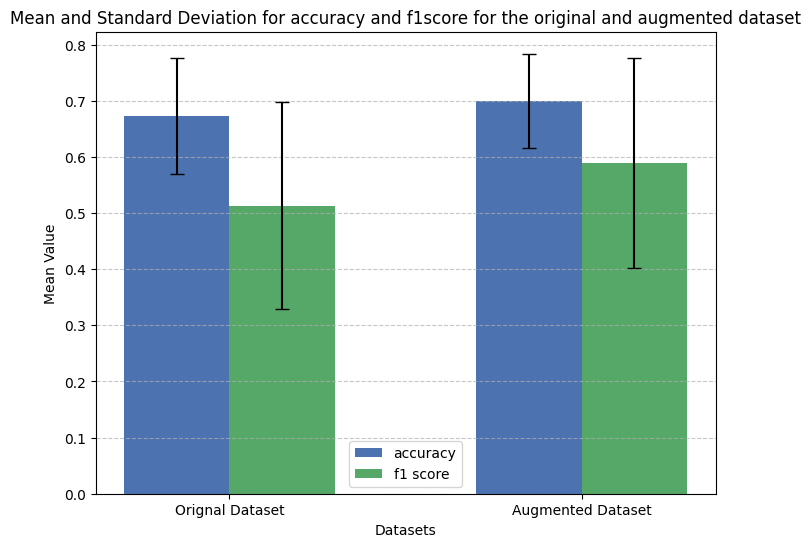

In [41]:

datasets = ['Orignal Dataset', 'Augmented Dataset']
metrics = ['accuracy', 'f1 score']

means = {
    'accuracy': [acc_mean, acc_mean_aug], 
    'f1 score': [f1_mean, f1_mean_aug]   
}


stds = {
    'accuracy': [acc_std, acc_std_aug],  
    'f1 score': [f1_std, f1_std_aug]   
}


x = np.arange(len(datasets)) 
width = 0.3 
fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(x - width/2, means['accuracy'], yerr=stds['accuracy'], 
              capsize=5, label='accuracy', color='#4C72B0', width=width)

bar2 = ax.bar(x + width/2, means['f1 score'], yerr=stds['f1 score'], 
              capsize=5, label='f1 score', color='#55A868', width=width)

ax.set_ylabel('Mean Value')
ax.set_xlabel('Datasets')
ax.set_title('Mean and Standard Deviation for accuracy and f1score for the original and augmented dataset')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Cnnplot.png")
plt.show()



## Let'see an example with a real image

In [32]:

img, mask,grt, f1 = find_best_image(device, DATA_PATH, MODEL_PATH,TRESHHOLD)
    

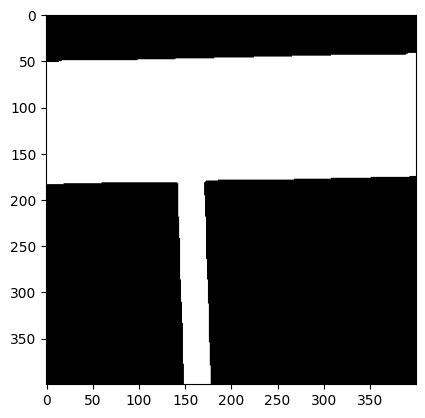

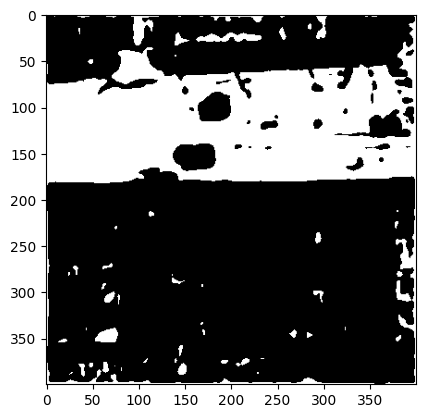

In [33]:
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plt.imshow(grt, cmap="gray")
plt.show()
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plt.imshow(mask, cmap="gray")
plt.show()

In [34]:
def save_mask(mask, path):
    mask = mask.squeeze(0).cpu().detach().numpy()
    mask = (mask > 0).astype(np.uint8)  # Convert to binary mask
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]  # Remove the last dimension if it is 1
    Image.fromarray(mask * 255).save(path)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "dataset/test"
OUTPUT_PATH = "dataset/test/predicted"
model = SatelliteRoadCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
dataset = SatDataset(DATA_PATH,training=False)
predictions = []
for id, img in enumerate(dataset):
    img = img.float().to(device)
    img = img.unsqueeze(0)
    mask = model(img)
    mask = mask.squeeze(0).squeeze(0).cpu().detach()
    pred_mask = torch.sigmoid(mask)
    pred_mask = (pred_mask >= TRESHHOLD).int().cpu()
    predictions.append(pred_mask)
   
    input_image_name = os.path.basename(dataset.images[id])
    output_name = f"predicted_{os.path.splitext(input_image_name)[0]}.png"
    save_mask(pred_mask, os.path.join(OUTPUT_PATH, output_name))

In [36]:
predicted = 'dataset/test/predicted/'
submission_csv = 'models/submission.csv'
names = [os.path.join(predicted, f) for f in os.listdir(predicted) if f.endswith('.png')]

# Ensure that the images are sorted to respect the order
names.sort(key=lambda x: int(re.search(r'\d+', x).group()))
print("Collected image filenames:")
for name in names:
    print(name)

# Use the mask_to_submission function to create a csv file in the correct format
masks_to_submission(submission_csv, *names)
print(f"Submission file {submission_csv} created successfully.")

Collected image filenames:
dataset/test/predicted/predicted_test_1.png
dataset/test/predicted/predicted_test_2.png
dataset/test/predicted/predicted_test_3.png
dataset/test/predicted/predicted_test_4.png
dataset/test/predicted/predicted_test_5.png
dataset/test/predicted/predicted_test_6.png
dataset/test/predicted/predicted_test_7.png
dataset/test/predicted/predicted_test_8.png
dataset/test/predicted/predicted_test_9.png
dataset/test/predicted/predicted_test_10.png
dataset/test/predicted/predicted_test_11.png
dataset/test/predicted/predicted_test_12.png
dataset/test/predicted/predicted_test_13.png
dataset/test/predicted/predicted_test_14.png
dataset/test/predicted/predicted_test_15.png
dataset/test/predicted/predicted_test_16.png
dataset/test/predicted/predicted_test_17.png
dataset/test/predicted/predicted_test_18.png
dataset/test/predicted/predicted_test_19.png
dataset/test/predicted/predicted_test_20.png
dataset/test/predicted/predicted_test_21.png
dataset/test/predicted/predicted_test